In [42]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
import time

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestClassifier



import kagglehub

path = kagglehub.dataset_download("yasserh/titanic-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Lucas\.cache\kagglehub\datasets\yasserh\titanic-dataset\versions\1


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
12

<Axes: ylabel='count'>

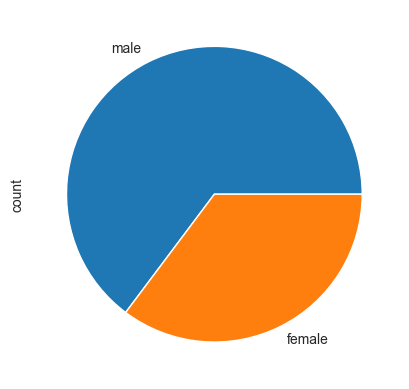

In [2]:
data = pd.read_csv('Titanic-Dataset.csv', sep=',')

print(data.head())
print(len(data.columns))


data['Sex'].value_counts().plot(kind='pie')

# Traitement des données : Valeurs manquantes

In [3]:
missing = data.isnull().sum()

print(missing) # il manque 177 dans age, 687 dans cabin et 2 dans embarked

data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)  # on prend la premiere valeur la plus frequent
data.drop(columns=['Cabin','Ticket'],errors='ignore', inplace=True)

print(missing) # il manque 177 dans age, 687 dans cabin et 2 dans embarked

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


# Traitement des données : Encodage

In [4]:
pd.get_dummies(data, columns=['Sex', 'Embarked'], drop_first=True)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,True,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,False,False,True
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,8.0500,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,13.0000,True,False,True
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,30.0000,False,False,True
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",28.0,1,2,23.4500,False,False,True
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,30.0000,True,False,False


In [5]:
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
print(data)
print(data['Title'].value_counts())


rare_titles = ['Dr', 'Rev', 'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer']
data['Title'] = data['Title'].apply(lambda x: x if x in ['Mr', 'Mrs', 'Miss', 'Master'] else 'Rare')
# data = data.loc[:, ~data.columns.str.startswith('Title_')]

print(data.columns)
print(data['Title'].value_counts())

label_encoder = LabelEncoder()

data['Title'] = label_encoder.fit_transform(data['Title'])

print(data.head())

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

In [6]:
women = data.loc[data.Sex == 'female']["Survived"]

rate_women = sum(women)/len(women)
                            
print(f"The percentage of women that survived is {rate_women}")

The percentage of women that survived is 0.7420382165605095


In [7]:
men = data.loc[data.Sex == 'male']["Survived"]

rate_men = sum(men) / len(men)

print(f"The percentage of men that survived is {rate_men}")

The percentage of men that survived is 0.18890814558058924


# Création du modèle 

In [8]:
print(data)
data['Sex'] = label_encoder.fit_transform(data['Sex'])
print("Sex:", dict(enumerate(label_encoder.classes_)))
data['Embarked'] = label_encoder.fit_transform(data['Embarked'])
print("Embarked:", dict(enumerate(label_encoder.classes_)))


     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

In [14]:
scaler = StandardScaler()

data[['Age', 'Fare']] = scaler.fit_transform(data[['Age','Fare']])

print(data)
X = data.drop(['PassengerId', 'Survived', 'Name'], axis=1)
y = data['Survived']

print(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=int(time.time()))


model = LogisticRegression(max_iter=2000)
model.fit(x_train,y_train)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name  Sex       Age  SibSp  \
0                              Braund, Mr. Owen Harris    1 -0.565736      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...    0  0.663861      1   
2                               Heikkinen, Miss. Laina    0 -0.258337      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  0.433312      1   
4                             Allen, Mr. William Henry    1  0.433312      0   
..                                                 ...  ...    

LogisticRegression(max_iter=2000)

In [20]:
y_pred = model.predict(x_test)

print(y_pred)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

# Rapport de classification
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matrice de confusion
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

[0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0
 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1
 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0
 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1]
Accuracy: 0.76

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82       114
           1       0.69      0.62      0.65        65

    accuracy                           0.76       179
   macro avg       0.74      0.73      0.73       179
weighted avg       0.76      0.76      0.76       179


Confusion Matrix:
 [[96 18]
 [25 40]]


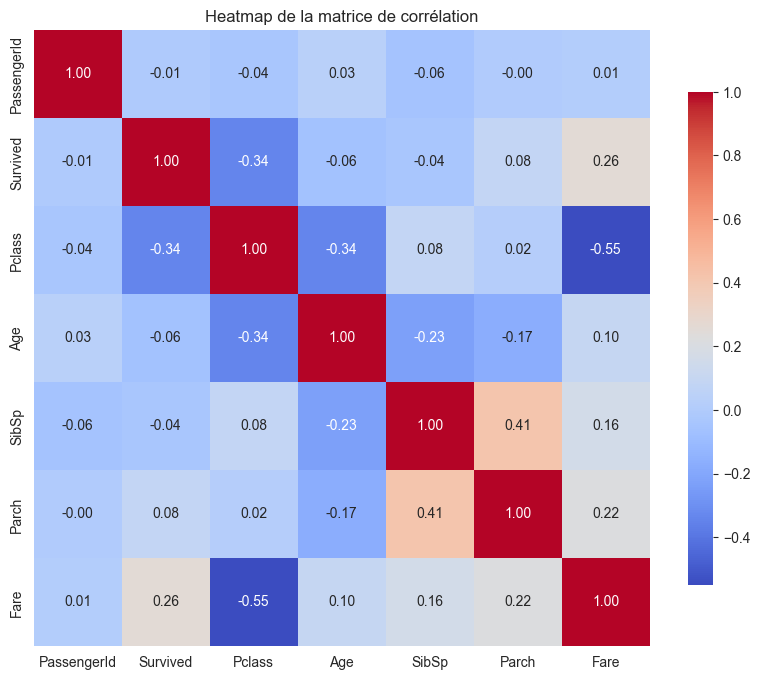

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

data_numeric = data.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(10, 8))
sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm', square=True, fmt=".2f", cbar_kws={'shrink': .8})
plt.title("Heatmap de la matrice de corrélation")
plt.show()

# Analyse de la Matrice de Corrélation du Dataset Titanic

## Comprendre la Corrélation
- Les valeurs de corrélation vont de -1 à 1.
  - Une corrélation proche de **1** indique une forte corrélation positive (quand une variable augmente, l'autre aussi).
  - Une corrélation proche de **-1** indique une forte corrélation négative (quand une variable augmente, l'autre diminue).
  - Une corrélation proche de **0** indique qu'il n'y a pas de lien linéaire direct entre les variables.

## Points Clés dans cette Matrice
1. **Survived et Pclass** : Corrélation de **-0.34**  
   - Plus la classe (`Pclass`) est élevée (par exemple, 3e classe), moins les chances de survie sont grandes.
   - Les passagers des classes supérieures semblent donc avoir de meilleures chances de survie.

2. **Survived et Fare** : Corrélation de **0.26**  
   - Il y a une faible corrélation positive entre le tarif payé et les chances de survie.
   - Cela peut indiquer que les passagers ayant payé un billet plus cher avaient un taux de survie légèrement supérieur.

3. **Pclass et Fare** : Corrélation de **-0.55**  
   - Les passagers des classes inférieures (classe 3, par exemple) ont tendance à payer moins cher leur billet.

## Autres Corrélations entre Variables
- **SibSp et Parch** : Corrélation de **0.41**  
  - Les passagers qui voyagent avec des frères/sœurs ou des conjoints (`SibSp`) ont également tendance à voyager avec des parents ou enfants (`Parch`).

- **Age et Pclass** : Corrélation de **-0.34**  
  - Les passagers plus jeunes sont plus susceptibles de se trouver dans les classes inférieures.

## Implications pour la Modélisation
- Les variables **Pclass** et **Fare** sont pertinentes pour prédire la survie, car elles montrent une certaine corrélation avec `Survived`.
- **SibSp et Parch** peuvent être combinées pour créer une nouvelle caractéristique, comme `FamilySize`, ce qui pourrait améliorer les prédictions.

# Essai avec algorithme de RandomForest


In [40]:
model = RandomForestClassifier(n_estimators=200, random_state=int(time.time()))
model.fit(x_train,y_train)

y_pred = model.predict(x_test)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Affichage des résultats
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.80
Precision: 0.75
Recall: 0.68
F1-Score: 0.71
ROC AUC: 0.77

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.85       114
           1       0.75      0.68      0.71        65

    accuracy                           0.80       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179


Confusion Matrix:
 [[99 15]
 [21 44]]


# RandomForest avec GridSearch

In [43]:
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [1, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]    
}

scorer = make_scorer(recall_score)
randomforest = RandomForestClassifier(random_state=int(time.time()))
grid_search = GridSearchCV(estimator=randomforest, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=10)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Meilleurs paramètres :", best_params)
print("Meilleur score de rappel (cross-validation) :", best_score)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(x_test)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Affichage des résultats
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Meilleurs paramètres : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Meilleur score de rappel (cross-validation) : 0.7618181818181817
Accuracy: 0.81
Precision: 0.76
Recall: 0.69
F1-Score: 0.73
ROC AUC: 0.78

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       114
           1       0.76      0.69      0.73        65

    accuracy                           0.81       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179


Confusion Matrix:
 [[100  14]
 [ 20  45]]
